# Harvard Forest Watershed


In [1]:
watershed='HarvardForest'

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC
import os
os.getcwd()
os.getcwd().rsplit('/',1)[0]

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/12-Harvard'

In [3]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,9999), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-50,50), 
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

### Discharge

In [4]:
# Discharge
data = pd.read_csv('http://harvardforest.fas.harvard.edu/data/p07/hf070/hf070-03-daily.csv',
                    header = 0,index_col = 'date', parse_dates = True,infer_datetime_format = True)
data.head()

jd  nt.dis f.nt.dis  bl.dis f.bl.dis  bu.dis f.bu.dis  nb.wt  \
date                                                                        
2007-12-21  355    1.21             2.48             0.64            1.32   
2007-12-22  356    1.19             2.46             0.64            1.46   
2007-12-23  357    5.16             4.75             2.52            1.72   
2007-12-24  358   21.62            30.91             7.59            1.30   
2007-12-25  359   11.89            12.27             1.67            1.34   

           f.nb.wt  bl.wt f.bl.wt  bu.wt f.bu.wt  
date                                              
2007-12-21           2.41           1.92          
2007-12-22           2.49           1.95          
2007-12-23           2.45           1.99          
2007-12-24           0.72           1.77          
2007-12-25           1.25           2.41

In [5]:
#prep = copy.deepcopy(data.drop([0]))
#prep.index = prep['datetime']
#prep = pd.DataFrame(pd.to_numeric(prep['68298_00060_00003']))
prep = copy.deepcopy(data.loc[:,['nt.dis','bl.dis','bu.dis']])
prep.columns = ['NelsonWeir_Discharge','BigelowLower_Discharge','BigelowUpper_Discharge']
prep = threC(prep,'Discharge')
display(prep.head(2))
prep.tail(2)

NelsonWeir_Discharge  BigelowLower_Discharge  \
date                                                       
2007-12-21                  1.21                    2.48   
2007-12-22                  1.19                    2.46   

            BigelowUpper_Discharge  
date                                
2007-12-21                    0.64  
2007-12-22                    0.64

NelsonWeir_Discharge  BigelowLower_Discharge  \
date                                                       
2020-08-30                  0.14                    2.78   
2020-08-31                  0.07                    1.37   

            BigelowUpper_Discharge  
date                                
2020-08-30                    0.78  
2020-08-31                    0.27

NelsonWeir_Discharge
BigelowLower_Discharge
BigelowUpper_Discharge


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

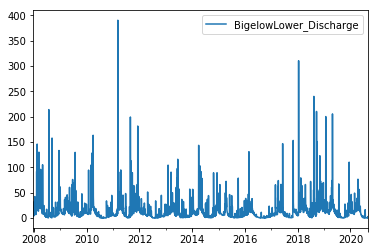

<Figure size 432x288 with 0 Axes>

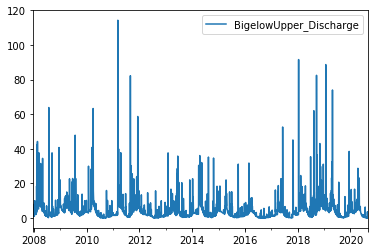

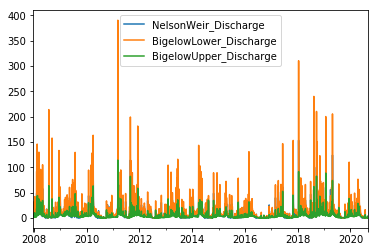

In [6]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Discharge unit should be L/s

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit(m3/s to L/s)
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'Discharge') 
Discharge = copy.deepcopy(df)
Discharge.plot()

### Hydrometeorology

### 2. Precipitation

In [7]:
# Precipitation1
data1 = pd.read_csv('http://harvardforest.fas.harvard.edu/data/p00/hf000/hf000-01-daily-m.csv',
                    header = 0,index_col = 'date' ,parse_dates = True, infer_datetime_format = True)
data1.head(3)

airt f.airt  airtmax f.airtmax  airtmin f.airtmin  prec f.prec
date                                                                      
1964-01-01 -14.0            -6.0              -21.0             0.0       
1964-01-02  -7.0             0.0              -14.0             6.4       
1964-01-03  -2.0             1.0               -4.0             0.0

In [8]:
# Precipitation2
data2 = pd.read_csv('http://harvardforest.fas.harvard.edu/data/p00/hf001/hf001-06-daily-m.csv',
                    header = 0, index_col = 'date', parse_dates = True, infer_datetime_format = True)
data2.head(3)

jd  airt f.airt  airtmax f.airtmax  airtmin f.airtmin    rh f.rh  \
date                                                                           
2001-02-11  42 -10.7    NaN     -6.9       NaN    -15.1       NaN  40.0  NaN   
2001-02-12  43  -9.8    NaN     -2.4       NaN    -17.4       NaN  45.0  NaN   
2001-02-13  44  -2.0    NaN      5.7       NaN     -7.3       NaN  70.0  NaN   

            rhmax  ...  wdev  f.wdev  gspd  f.gspd s10t  f.s10t s10tmax  \
date               ...                                                    
2001-02-11   58.0  ...  27.0     NaN  15.4     NaN  NaN       M     NaN   
2001-02-12   85.0  ...  55.0     NaN   7.2     NaN  NaN       M     NaN   
2001-02-13  100.0  ...  53.0     NaN   9.6     NaN  NaN       M     NaN   

            f.s10tmax s10tmin  f.s10tmin  
date                                      
2001-02-11          M     NaN          M  
2001-02-12          M     NaN          M  
2001-02-13          M     NaN          M  

[3 rows x 45 columns]

In [9]:
ppt1 = copy.deepcopy(data1[['prec']])
ppt1.columns=['HF000_Precipitation'] 
ppt2 = copy.deepcopy(data2[['prec']])
ppt2.columns=['HF001_Precipitation'] 
#df_lst=[ppt1,ppt2]
df_lst=[ppt2]
prep = aggre_and_comb_daily(df_lst, axis=1, func = "sum") 

The final table is:


HF001_Precipitation
2001-02-11                   0
2001-02-12                   0

HF001_Precipitation
2020-08-30                   0
2020-08-31                   0

HF001_Precipitation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

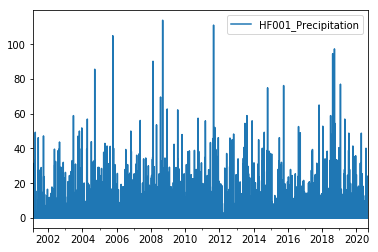

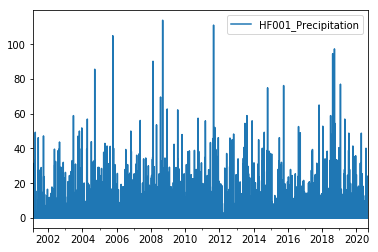

In [10]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Precipitation unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'Precipitation')     
Precipitation = copy.deepcopy(df)
Precipitation.plot()

### 3. AirTemperature

In [11]:
at1 = copy.deepcopy(data1[['airt']])
at1.columns=['HF000_AirTemperature'] 
at2 = copy.deepcopy(data2[['airt']])
at2.columns=['HF001_AirTemperature'] 
df_lst=[at2] ##### not inclusing at1
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

The final table is:


HF001_AirTemperature
2001-02-11                -10.7
2001-02-12                 -9.8

HF001_AirTemperature
2020-08-30                 16.5
2020-08-31                 15.5

HF001_AirTemperature


<Figure size 432x288 with 0 Axes>

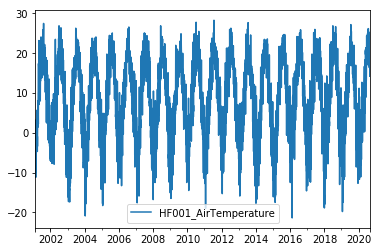

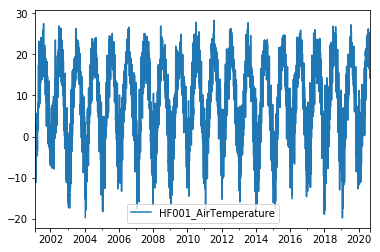

In [12]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Air Temperature unit should be Degree celsius

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 


for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'AirTemperature')   
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()

### 4. SolarRadiation

HF001_SolarRadiation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

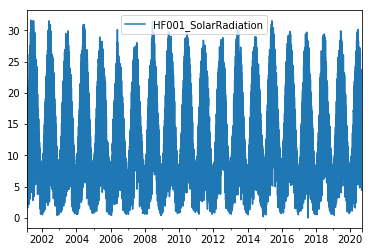

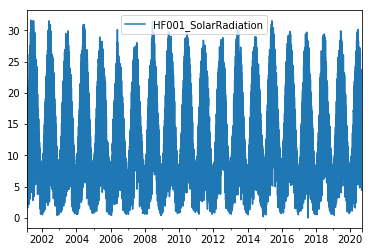

In [13]:
# One site codes
prep = copy.deepcopy(data2[['slrt']])
prep.columns=['HF001_SolarRadiation'] 

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'SolarRadiation')  
SolarRadiation = copy.deepcopy(df)
SolarRadiation.plot()

### 5. RelativeHumidity

HF001_RelativeHumidity


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

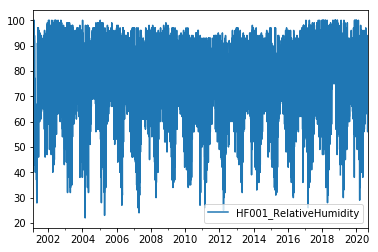

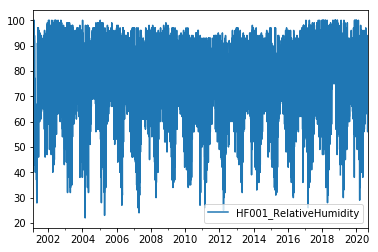

In [14]:
# One site codes
prep = copy.deepcopy(data2[['rh']])
prep.columns=['HF001_RelativeHumidity'] 

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'RelativeHumidity')  
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()

### 6. WindDirection

HF001_WindDirection


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

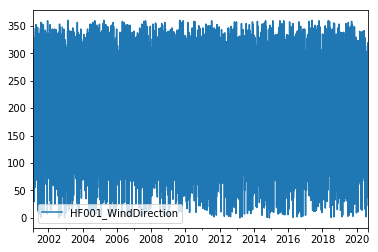

In [15]:
# One site codes
prep = copy.deepcopy(data2[['wdir']])
prep.columns=['HF001_WindDirection'] 

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'WindDirection')  
WindDirection = copy.deepcopy(df)
WindDirection.plot()

### 7. WindSpeed

HF001_WindSpeed


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

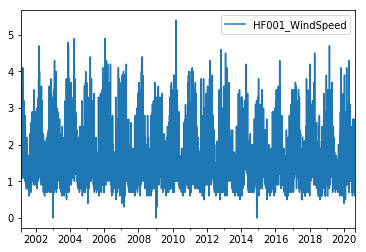

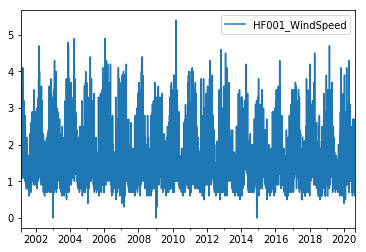

In [16]:
# One site codes
prep = copy.deepcopy(data2[['wspd']])
prep.columns=['HF001_WindSpeed'] 

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'WindSpeed')  
WindSpeed = copy.deepcopy(df)
WindSpeed.plot()

### 8. SWE

In [17]:
data3 = pd.read_csv('http://harvardforest.fas.harvard.edu/data/p15/hf155/hf155-01-daily.csv',
                    header = 0, index_col = 'date', parse_dates = True, infer_datetime_format = True)
data3.head(2)

jd   swe f.swe
date                       
2009-12-05  339  2.84   NaN
2009-12-06  340  7.39   NaN

In [18]:
# HF237
data4 = pd.read_csv('http://harvardforest.fas.harvard.edu/data/p23/hf237/hf237-01-snow-depth.csv',
                    header = 0, index_col = 'date', parse_dates = True, infer_datetime_format = True)
data4.head(3)

year  doy  shaler.depth  shaler.density  shaler.swe  lph.depth  \
date                                                                         
2008-12-01  2008  336           NaN             NaN         NaN        NaN   
2008-12-02  2008  337           NaN             NaN         NaN        NaN   
2008-12-03  2008  338           NaN             NaN         NaN        NaN   

            lph.density  lph.swe  hemlock.depth  hemlock.density  hemlock.swe  
date                                                                           
2008-12-01          NaN      NaN            NaN              NaN          NaN  
2008-12-02          NaN      NaN            NaN              NaN          NaN  
2008-12-03          NaN      NaN            NaN              NaN          NaN

In [19]:
swe1 = copy.deepcopy(data3[['swe']])
swe1.columns=['HF155_SWE']
swe2 = copy.deepcopy(data4[['shaler.swe','lph.swe','hemlock.swe']])
swe2.columns=['Shaler_SWE','LittleProspectHill_SWE','Hemlock_SWE']
df_lst=[swe1,swe2]
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

The final table is:


HF155_SWE Shaler_SWE LittleProspectHill_SWE Hemlock_SWE
2008-12-01       NaN        NaN                    NaN         NaN
2008-12-02       NaN        NaN                    NaN         NaN

HF155_SWE Shaler_SWE LittleProspectHill_SWE Hemlock_SWE
2020-08-30         0        NaN                    NaN         NaN
2020-08-31         0        NaN                    NaN         NaN

HF155_SWE
Shaler_SWE
LittleProspectHill_SWE
Hemlock_SWE


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

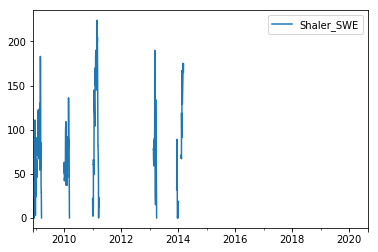

<Figure size 432x288 with 0 Axes>

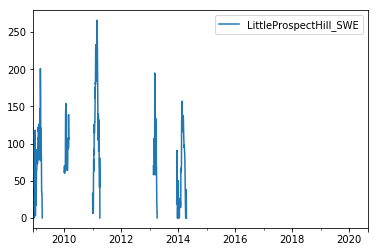

<Figure size 432x288 with 0 Axes>

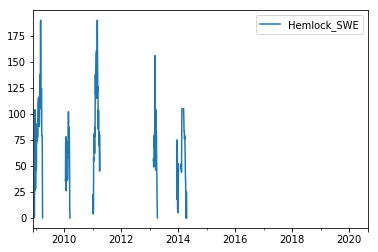

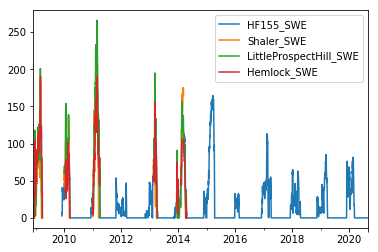

In [20]:
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit to mm
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'SWE')  
SWE = copy.deepcopy(df)
SWE.plot()

### 9. SnowDepth

In [21]:
prep = copy.deepcopy(data4[['shaler.depth','lph.depth','hemlock.depth']])
prep.columns=['Shaler_SnowDepth','LittleProspectHill_SnowDepth','Hemlock_SnowDepth']

Shaler_SnowDepth
LittleProspectHill_SnowDepth
Hemlock_SnowDepth


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

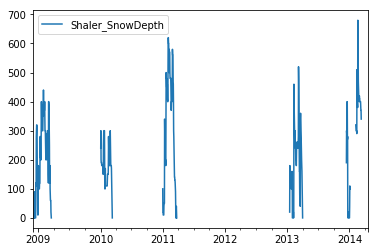

<Figure size 432x288 with 0 Axes>

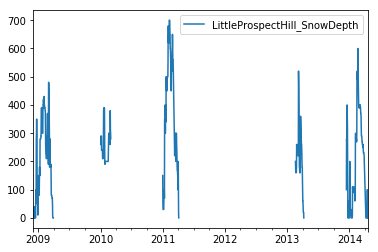

<Figure size 432x288 with 0 Axes>

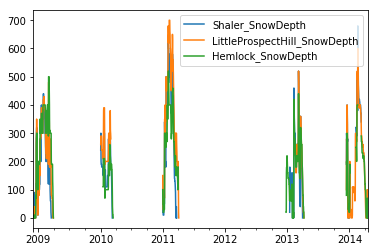

In [22]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Snowdepth unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*10  # convert to the right unit to mm
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'SnowDepth')  
SnowDepth = copy.deepcopy(df)
SnowDepth.plot()

### 11. SoilMoisture

In [37]:
data = pd.read_csv('http://harvardforest.fas.harvard.edu/data/p26/hf260/hf260-01-hf-soil-temp-moist.csv',
                    header = 0, index_col = 'date', parse_dates = True, infer_datetime_format = True)
data.head(2)

reading.id                 site   plot             datetime  \
date                                                                      
2011-11-18       10759  Harvard Forest LTER  HFRT1  2011-11-18T12:00:00   
2011-11-18       10760  Harvard Forest LTER  HFRT1  2011-11-18T13:00:00   

                time  soilt  water.content error  
date                                              
2011-11-18  12:00:00  6.484         0.1019   NaN  
2011-11-18  13:00:00  6.458         0.1036   NaN

In [38]:
df_lst=[]
for p in data['plot'].unique():
    df=data[data['plot']==p][['water.content']]*100
    df.columns=[str(p)+'_SoilMoisture']
    df=threC(df,'SoilMoisture')
    display(df.head())
    df_lst.append(df)
prep1 = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

HFRT1_SoilMoisture
date                          
2011-11-18               10.19
2011-11-18               10.36
2011-11-18               10.30
2011-11-18               10.42
2011-11-18               10.42

HFRT2_SoilMoisture
date                          
2011-11-18                 NaN
2011-11-18                 NaN
2011-11-18                 NaN
2011-11-18                 NaN
2011-11-18                 NaN

HFRT3_SoilMoisture
date                          
2011-11-18                8.59
2011-11-18                8.65
2011-11-18                8.65
2011-11-18                8.70
2011-11-18                8.70

HFRT4_SoilMoisture
date                          
2011-11-18                 NaN
2011-11-18                 NaN
2011-11-18                 NaN
2011-11-18                 NaN
2011-11-18                 NaN

HFRT5_SoilMoisture
date                          
2011-11-18                 NaN
2011-11-18                 NaN
2011-11-18                 NaN
2011-11-18                 NaN
2011-11-18                 NaN

['HFRT2_SoilMoisture', datetime.date(2012, 1, 27)]
nan ratio is 0.08333333333333333 , groupby value is 2.2413636363636362
['HFRT5_SoilMoisture', datetime.date(2012, 1, 5)]
nan ratio is 0.041666666666666664 , groupby value is 1.2034782608695653
['HFRT5_SoilMoisture', datetime.date(2012, 5, 18)]
nan ratio is 0.08333333333333333 , groupby value is 0.12363636363636363
The final table is:


HFRT1_SoilMoisture HFRT2_SoilMoisture HFRT3_SoilMoisture  \
2011-11-18            10.4492                NaN             8.7275   
2011-11-19            10.5929                NaN            8.86458   

           HFRT4_SoilMoisture HFRT5_SoilMoisture  
2011-11-18                NaN                NaN  
2011-11-19                NaN                NaN

HFRT1_SoilMoisture HFRT2_SoilMoisture HFRT3_SoilMoisture  \
2012-11-16            10.5129                NaN                NaN   
2012-11-17            10.2692                NaN                NaN   

           HFRT4_SoilMoisture HFRT5_SoilMoisture  
2012-11-16                NaN                NaN  
2012-11-17                NaN                NaN

In [39]:
data5 = pd.read_csv('http://harvardforest.fas.harvard.edu/data/p00/hf006/hf006-05-root-exclusion.csv',
                    header = 0, index_col = 'date', parse_dates = True, infer_datetime_format = True)
data5.head(2)
prep2 = copy.deepcopy(data5[['vsm.t','vsm.c']])*100
prep2 = threC(prep2,'SoilMoisture')
prep2.columns=['HF006_SoilMoisture_trenched','HF006_SoilMoisture_control']

['HF006_SoilMoisture_trenched', datetime.date(2012, 5, 31)]
nan ratio is 0.008333333333333333 , groupby value is 18.676470588235293
['HF006_SoilMoisture_trenched', datetime.date(2012, 7, 22)]
nan ratio is 0.008645533141210375 , groupby value is 4.0
['HF006_SoilMoisture_trenched', datetime.date(2014, 5, 29)]
nan ratio is 0.01953125 , groupby value is 26.0
['HF006_SoilMoisture_control', datetime.date(2012, 7, 11)]
nan ratio is 0.0026246719160104987 , groupby value is 7.000000000000001
['HF006_SoilMoisture_control', datetime.date(2012, 7, 23)]
nan ratio is 0.010416666666666666 , groupby value is 4.866666666666666
['HF006_SoilMoisture_control', datetime.date(2014, 5, 29)]
nan ratio is 0.0234375 , groupby value is 24.872
The final table is:


HFRT1_SoilMoisture HFRT2_SoilMoisture HFRT3_SoilMoisture  \
2011-11-18            10.4492                NaN             8.7275   
2011-11-19            10.5929                NaN            8.86458   

           HFRT4_SoilMoisture HFRT5_SoilMoisture HF006_SoilMoisture_trenched  \
2011-11-18                NaN                NaN                         NaN   
2011-11-19                NaN                NaN                         NaN   

           HF006_SoilMoisture_control  
2011-11-18                        NaN  
2011-11-19                        NaN

HFRT1_SoilMoisture HFRT2_SoilMoisture HFRT3_SoilMoisture  \
2014-11-16                NaN                NaN                NaN   
2014-11-17                NaN                NaN                NaN   

           HFRT4_SoilMoisture HFRT5_SoilMoisture HF006_SoilMoisture_trenched  \
2014-11-16                NaN                NaN                          21   
2014-11-17                NaN                NaN                     24.7266   

           HF006_SoilMoisture_control  
2014-11-16                         19  
2014-11-17                    20.0625

In [ ]:
prep = aggre_and_comb_daily([prep1,prep2], axis=1, func = "mean") 

HFRT1_SoilMoisture
HFRT2_SoilMoisture
HFRT3_SoilMoisture
HFRT4_SoilMoisture
HFRT5_SoilMoisture
HF006_SoilMoisture_trenched
HF006_SoilMoisture_control


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

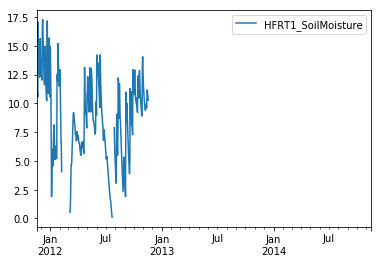

<Figure size 432x288 with 0 Axes>

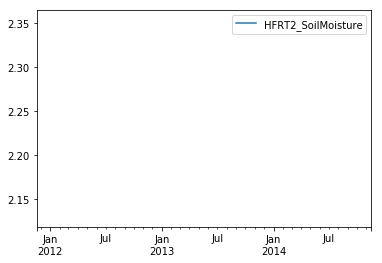

<Figure size 432x288 with 0 Axes>

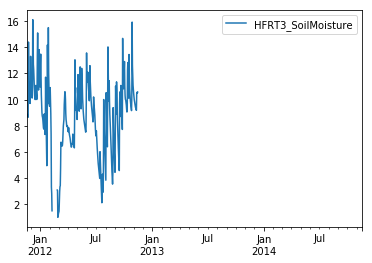

<Figure size 432x288 with 0 Axes>

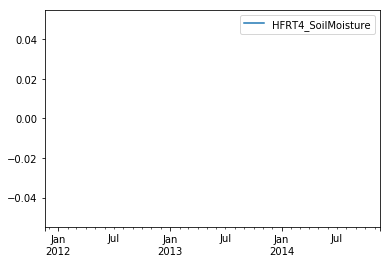

<Figure size 432x288 with 0 Axes>

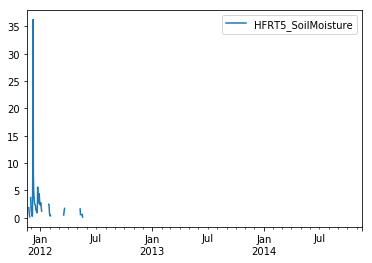

<Figure size 432x288 with 0 Axes>

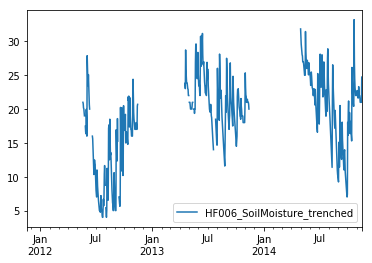

<Figure size 432x288 with 0 Axes>

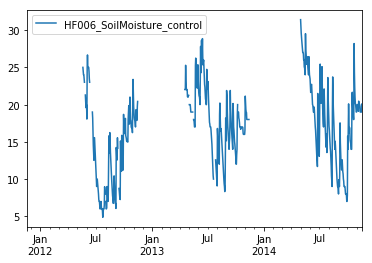

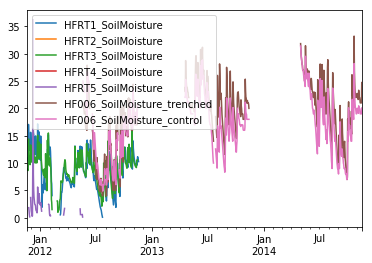

In [40]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SoilMoisture data should be %

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'SoilMoisture')      
SoilMoisture = copy.deepcopy(df)
SoilMoisture.plot()

### 12. SoilTemperature

In [29]:
data = pd.read_csv('http://harvardforest.fas.harvard.edu/data/p00/hf001/hf001-06-daily-m.csv',
                    header = 0, index_col = 'date', parse_dates = True, infer_datetime_format = True)
data.head(2)

jd  airt f.airt  airtmax f.airtmax  airtmin f.airtmin    rh f.rh  \
date                                                                           
2001-02-11  42 -10.7    NaN     -6.9       NaN    -15.1       NaN  40.0  NaN   
2001-02-12  43  -9.8    NaN     -2.4       NaN    -17.4       NaN  45.0  NaN   

            rhmax  ...  wdev  f.wdev  gspd  f.gspd s10t  f.s10t s10tmax  \
date               ...                                                    
2001-02-11   58.0  ...  27.0     NaN  15.4     NaN  NaN       M     NaN   
2001-02-12   85.0  ...  55.0     NaN   7.2     NaN  NaN       M     NaN   

            f.s10tmax s10tmin  f.s10tmin  
date                                      
2001-02-11          M     NaN          M  
2001-02-12          M     NaN          M  

[2 rows x 45 columns]

HF001_SoilTemperature_10cm


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

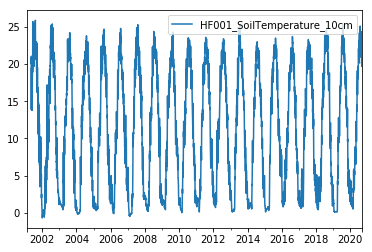

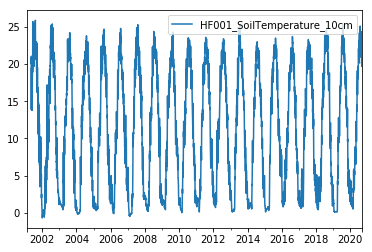

In [30]:
prep = copy.deepcopy(data[['s10t']])
prep.columns=['HF001_SoilTemperature_10cm']
prep = threC(prep,'SoilTemperature')
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]) )  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'SoilTemperature')     
SoilTemperature = copy.deepcopy(df)
SoilTemperature.plot()

In [31]:
# Put all the tables to the same date format
# data_soil.index= pd.to_datetime(data_soil.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data.index= pd.to_datetime(data.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data_lwr.index= pd.to_datetime(data_lwr.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S

# Bring them together
result1 = pd.concat([Discharge,Precipitation,AirTemperature,SolarRadiation,RelativeHumidity,
                     WindDirection,WindSpeed,SWE,SnowDepth,SoilMoisture,SoilTemperature], axis=1,
                    join='outer')

In [32]:
result1.index.rename('DateTime', inplace = True)
result1.head(5)# All data are from HF001 met site

NelsonWeir_Discharge  BigelowLower_Discharge  \
DateTime                                                   
2001-02-11                   NaN                     NaN   
2001-02-12                   NaN                     NaN   
2001-02-13                   NaN                     NaN   
2001-02-14                   NaN                     NaN   
2001-02-15                   NaN                     NaN   

            BigelowUpper_Discharge  HF001_Precipitation  HF001_AirTemperature  \
DateTime                                                                        
2001-02-11                     NaN                  0.0                 -10.7   
2001-02-12                     NaN                  0.0                  -9.8   
2001-02-13                     NaN                  0.0                  -2.0   
2001-02-14                     NaN                  6.9                  -0.5   
2001-02-15                     NaN                  0.0                  -0.4   

            HF001_SolarRadiation  HF001_RelativeHumidity  HF001_WindDirection  \
DateTime                                                                        
2001-02-11                  14.9                    40.0                287.0   
2001-02-12                  14.8                    45.0                245.0   
2001-02-13                  14.8                    70.0                278.0   
2001-02-14                   2.6                    78.0                197.0   
2001-02-15                  10.5                    69.0                300.0   

            HF001_WindSpeed  HF155_SWE  Shaler_SWE  LittleProspectHill_SWE  \
DateTime                                                                     
2001-02-11              3.3        NaN         NaN                     NaN   
2001-02-12              1.7        NaN         NaN                     NaN   
2001-02-13              1.7        NaN         NaN                     NaN   
2001-02-14              2.5        NaN         NaN                     NaN   
2001-02-15              1.6        NaN         NaN                     NaN   

            Hemlock_SWE  Shaler_SnowDepth  LittleProspectHill_SnowDepth  \
DateTime                                                                  
2001-02-11          NaN               NaN                           NaN   
2001-02-12          NaN               NaN                           NaN   
2001-02-13          NaN               NaN                           NaN   
2001-02-14          NaN               NaN                           NaN   
2001-02-15          NaN               NaN                           NaN   

            Hemlock_SnowDepth  HF006_SoilMoisture_trenched  \
DateTime                                                     
2001-02-11                NaN                          NaN   
2001-02-12                NaN                          NaN   
2001-02-13                NaN                          NaN   
2001-02-14                NaN                          NaN   
2001-02-15                NaN                          NaN   

            HF006_SoilMoisture_control  HF001_SoilTemperature_10cm  
DateTime                                                            
2001-02-11                         NaN                         NaN  
2001-02-12                         NaN                         NaN  
2001-02-13                         NaN                         NaN  
2001-02-14                         NaN                         NaN  
2001-02-15                         NaN                         NaN

In [33]:
# Write data to csv for further inspection
result1.to_csv('1_HarvardForest_Download_Aggregation_Daily.csv', sep=',')